### Example 1

#### Data Generation
Set the model parameters like dimension and standard error, and store the two centers (each is a two-dim vector) in `m1` and `m2`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import linear_model as lm

np.random.seed(100)

p = 2
s = 1      # sd for generating x       
m1 = [1,0]
m0 = [0,1]

Next we generate  n samples from each normal component.
- First, we generate a 2n-by-p matrix with entries being iid samples form a normal dist with mean 0 and standard deviation `s`.
- Then we form a 2n-by-p matrix with the first n rows being the two-dimensional vector `m1` (the center of the first normal component) and the next n rows being `m2`.

In [2]:
n = 100  # generate the train data; n for each class
traindata = np.random.normal(size = (2 * n, p)) * s \
            + np.concatenate([np.array([m1] * n), np.array([m0] * n)])
Ytrain = np.concatenate(([1]*n, [0]*n))
traindata.shape

(200, 2)

Generate `2N` test samples similarly.

In [3]:
N = 5000
testdata = np.random.normal(size = (2 * N, p)) * s \
           + np.concatenate([np.array([m1] * N), np.array([m0] * N)])
Ytest = np.concatenate(([1]*N, [0]*N))

#### Visulization
Before running any analysis, we can take a look of the data. In the figure generated by the code below, points from two groups are colored in red and blue, respectively; the two centers are plotted as +, and a legend is added to explain the association of each color.

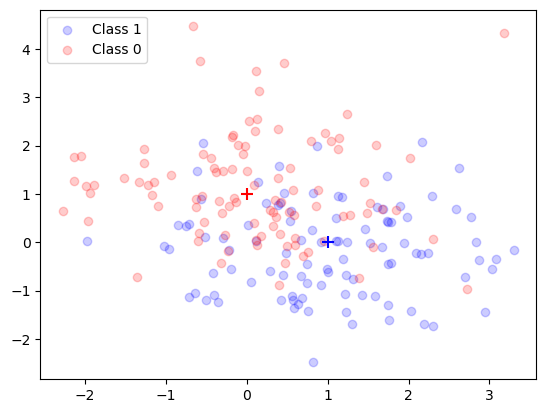

In [4]:
plt.scatter(traindata[:n, 0], traindata[:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(traindata[n:, 0], traindata[n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[0], m1[1], marker = '+', s = 80, c = "blue")
plt.scatter(m0[0], m0[1], marker = '+', s = 80, c = "red")

plt.legend()
plt.show()

#### K-NN method¶
For choices of the neighhood size, I just use the values from the textbook.

In [5]:
myk = [151, 101, 69, 45, 31, 21, 11, 7, 5, 3, 1]

train_err_knn = []
test_err_knn = []

for j in myk:
    myknn = knn(n_neighbors = j)
    myknn.fit(traindata, Ytrain)
    train_err_knn.append(1 - myknn.score(traindata, Ytrain))
    test_err_knn.append(1- myknn.score(testdata, Ytest))

In [6]:
np.column_stack((train_err_knn, test_err_knn))

array([[0.25  , 0.2476],
       [0.25  , 0.2489],
       [0.24  , 0.2438],
       [0.23  , 0.249 ],
       [0.22  , 0.2572],
       [0.24  , 0.2647],
       [0.195 , 0.2745],
       [0.23  , 0.2832],
       [0.195 , 0.2891],
       [0.185 , 0.2922],
       [0.    , 0.3415]])

Use the code below if you want to use 5-fold CV to select the optimal K, i.e., the k value in myk that minimizes the CV error.

The 5-fold CV error for each k is a sum of 5 prediction errors, one for each fold. In the code below, we have an outside loop from 1 to 5, and an inside loop from 1 to m (all possible values for k). Inside the loop, we use 80\% (i.e., four folds) of the data as training and predict on the 20\% (i.e., one fold) holdout set.

In [7]:
# Define the number of folds
num_folds = 5
n = len(Ytrain)
m = len(myk)
cverr = np.zeros(m)

indices = np.arange(n)
np.random.shuffle(indices)
index_sets = np.array_split(indices, num_folds)

for ifold in range(num_folds):
    train_indices =  np.delete(index_sets, obj=ifold, axis=0).ravel()
    _traindata = traindata[train_indices]
    _Ytrain = Ytrain[train_indices]
    
    test_indices = index_sets[ifold]
    _testdata = traindata[test_indices]
    _Ytest = Ytrain[test_indices]
   
    for j in range(m):
        K = myk[j]
        knn_model = knn(K)
        knn_model.fit(_traindata, _Ytrain)
        predict_Y = knn_model.predict(_testdata)
        cverr[j] += sum(predict_Y != _Ytest)
    
cverr /= float(n)
cverr

array([0.43 , 0.27 , 0.245, 0.245, 0.26 , 0.26 , 0.25 , 0.275, 0.275,
       0.305, 0.35 ])

Find the best k value based 5-fold CV.

In [8]:
best_k_index = np.argmin(cverr)
best_k = myk[best_k_index]
best_k

69

Compute the error of KNN when K is chosen by 5-fold CV

In [9]:
knn_model = knn(best_k)
knn_model.fit(traindata, Ytrain)
train_err_cvknn = 1 - myknn.score(traindata, Ytrain)
test_err_cvknn = 1- myknn.score(testdata, Ytest)

#### Least Sqaure Method

In [10]:
RegModel = lm.LinearRegression()
RegModel.fit(traindata, Ytrain)

Ytrain_pred_LS = RegModel.predict(traindata)
Ytest_pred_LS = RegModel.predict(testdata)

Ytrain_pred_LS = [1 if i >= 0.5 else 0 for i in Ytrain_pred_LS]
Ytest_pred_LS = [1 if i >= 0.5 else 0 for i in Ytest_pred_LS]

train_err_LS = sum(Ytrain != Ytrain_pred_LS) / float(2*n)
test_err_LS = sum(Ytest != Ytest_pred_LS) / float(2*N)

#### Bayes Error

In [11]:
def myfun(x):
    return 2*np.dot(x, np.subtract(m1, m0)) - (np.dot(m1, m1) - np.dot(m0, m0))

Ytest_pred_Bayes = [myfun(x) > 0 for x in testdata]
test_err_Bayes = sum(Ytest !=  Ytest_pred_Bayes) / float(2*N)

#### Plot the Performance
Test errors are in red and training errors are in blue. The upper x-coordinate indicates the K values, and the lower x-coordinate indicates the degree-of-freedom of the KNN procedures so the labels are reciprocally related to K.

The training and test errors for linear regression are plotted at df=3, since the linear model has 3 parameters, i.e., 3 dfs.

The training and test errors for cvKNN with K chosen by CV are plotted at the chose K values.

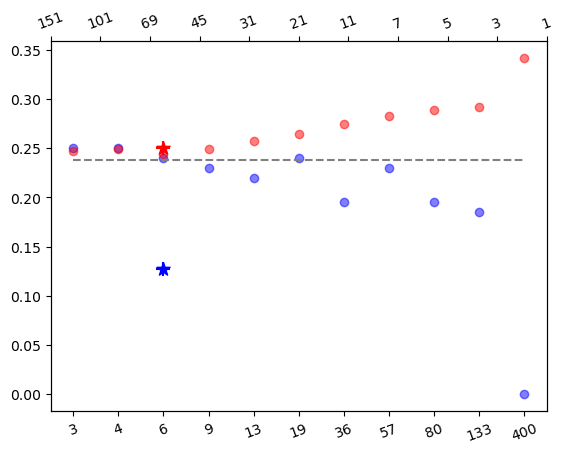

In [12]:
m = len(myk)
df = np.rint((2*n) / np.array(myk))
df = df.astype(int)

fig, ax1 = plt.subplots()

plt.scatter(range(m), train_err_knn, alpha = 0.5, c = "blue")
plt.scatter(range(m), test_err_knn, alpha = 0.5, c = "red")

plt.scatter(2, train_err_LS, marker = '+', s = 100, c = "blue")
plt.scatter(2, test_err_LS, marker = '+',  s = 100, c = "red")

plt.hlines(test_err_Bayes, 0, m-1, color = "gray", linestyle='--')

plt.scatter(best_k_index, train_err_LS, marker = '*', s = 100, c = "blue")
plt.scatter(best_k_index, test_err_LS, marker = '*',  s = 100, c = "red")

plt.xticks(range(m), df, rotation = 20)
ax2 = ax1.twiny()
ax2.set_xticks(range(m))
ax2.set_xticklabels(myk, rotation = 20)

plt.show()

### Example II
#### Data Generation
Generate the 20 centers, 10 for each group.

In [13]:
csize = 10      
p = 2      
s = 1;      # sd for generating the centers within each class                    
m1 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[0, 1]] * csize)])

Generate training data.

In [14]:
n = 100
# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = n)
id0 = np.random.randint(csize, size = n)

# sd for generating data  
s = np.sqrt(float(1)/5) 

traindata = np.random.normal(size = (2 * n, p)) * s \
            + np.concatenate([m1[id1,:], m0[id0,:]])
ytrain = np.concatenate(([1]*n, [0]*n))

#### Visulization

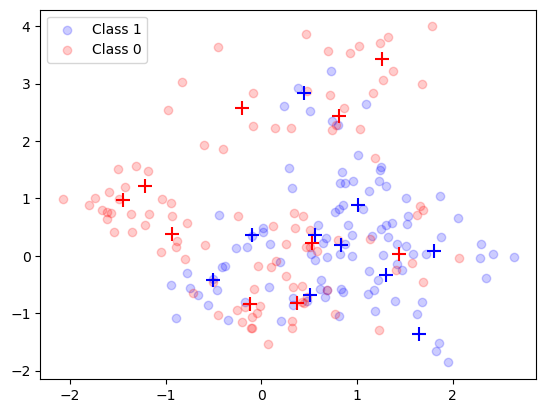

In [15]:
plt.scatter(traindata[:n, 0], traindata[:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(traindata[n:, 0], traindata[n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()